In [8]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from copy import deepcopy
import math

In [9]:
resolution = 1024
num_levels = 3

train_loader_list, test_loader_list, data_processor_list = load_darcy_flow(
    root_dir="data",
    dataset_name="darcy_ZD_PWC",
    n_train=1000,
    n_tests=[50],
    batch_size=20,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    decompose_multigrid=True,
    L=num_levels
)

/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(


Loading test db for resolution 1024 with 50 samples 


/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(Path(root_dir).joinp

In [10]:
train_loader_list[0].dataset.x.shape, train_loader_list[0].dataset.y.shape, train_loader_list[0].dataset.x.min(), train_loader_list[0].dataset.x.max(), train_loader_list[0].dataset.y.min(), train_loader_list[0].dataset.y.max()

(torch.Size([1000, 4, 128, 128]),
 torch.Size([1000, 1, 128, 128]),
 tensor(0.),
 tensor(12.),
 tensor(0., dtype=torch.float64),
 tensor(0.0059, dtype=torch.float64))

In [11]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [12]:
save_dir = "./experiments/tfno_models"
loaded_models = []

for i in range(len(data_processor_list)):  
    model_path = os.path.join(save_dir, f"tfno_model_{i}.pth")

    model = TFNO(
        n_modes=(16, 16),
        hidden_channels=64,
        in_channels=num_levels+1,   # same as training
        out_channels=1,
        factorization='tucker',
        implementation='factorized',
        rank=0.05
    ).to(device)

    
    model.load_state_dict(torch.load(model_path, map_location=device))

    #model.eval()  # set to evaluation mode
    loaded_models.append(model)

print(f"Loaded {len(loaded_models)} models")

/tmp/ipykernel_570897/1713088587.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 64 models


In [13]:
len(loaded_models)

64

In [33]:
def stitch_predictions(models, test_loader_list, data_processor_list,
                       global_res, device):
    # Assume all models have the same local resolution
    local_res = models[0].out_channels_size if hasattr(models[0], "out_channels_size") else \
                next(iter(test_loader_list[0].values())).dataset.y.shape[-1]

    num_per_axis = global_res // local_res
    num_models = num_per_axis ** 2

    full_output = None
    batch_size = None

    with torch.no_grad():
        for idx, model in enumerate(models):
            dp = data_processor_list[idx].to(device)
            loader = test_loader_list[idx][global_res]

            xb = loader.dataset.x.to(device)   # [batch, in_channels, local_res, local_res]
            y_pred = model(xb)
            y_pred = dp.out_normalizer.inverse_transform(y_pred)

            if full_output is None:
                batch_size = y_pred.shape[0]
                full_output = torch.zeros(batch_size, 1, global_res, global_res, device=device)

            # Compute tile position
            i = idx // num_per_axis  # row index
            j = idx % num_per_axis   # col index
            r_start, r_end = i * local_res, (i + 1) * local_res
            c_start, c_end = j * local_res, (j + 1) * local_res

            full_output[:, :, r_start:r_end, c_start:c_end] = y_pred

    return full_output

def plot_comparison(y_full, y_reconstructed):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    im0 = axs[0].imshow(y_full.squeeze().cpu(), cmap='viridis')
    axs[0].set_title("Original Solution")
    fig.colorbar(im0, ax=axs[0])
    """
    im1 = axs[1].imshow(y_tfno.squeeze().cpu(), cmap='viridis')
    axs[1].set_title("Full TFNO Prediction")
    fig.colorbar(im1, ax=axs[1])12
    """
    
    im2 = axs[1].imshow(y_reconstructed.squeeze().cpu(), cmap='viridis')
    axs[1].set_title("Reconstructed from Subdomains")
    fig.colorbar(im2, ax=axs[1])

    im3 = axs[2].imshow((y_reconstructed - y_full).abs().squeeze().cpu(), cmap='inferno')
    axs[2].set_title("Reconstruction Error")
    fig.colorbar(im3, ax=axs[2])

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [29]:
resolution = 1024

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=20,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution]
)

/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(


Loading test db for resolution 1024 with 50 samples 


/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(Path(root_dir).joinp

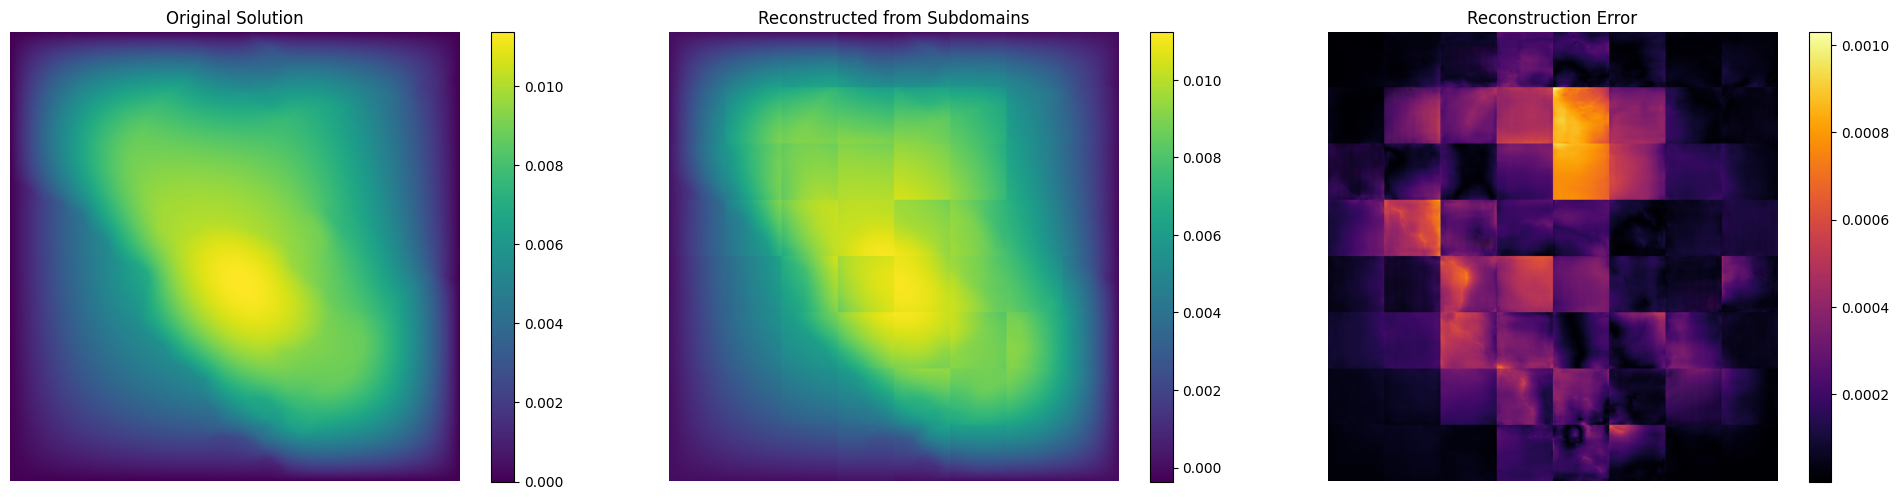

L2 error (MG-TFNO) : 0.042401368154439775


In [34]:
random_index = np.random.randint(0, test_loaders[resolution].dataset.x.shape[0] - 1)

# Reconstruct output from subdomains
y_reconstructed = stitch_predictions(loaded_models, test_loader_list, data_processor_list, resolution, device)

# Get ground truth solution
y_full = test_loaders[resolution].dataset.y[random_index:random_index+1].to(device)

# Plot original, TFNO, subdomain reconstruction
plot_comparison(y_full, y_reconstructed[random_index:random_index+1])

print(f'L2 error (MG-TFNO) : {torch.norm(y_full - y_reconstructed[random_index:random_index+1]) / torch.norm(y_full)}')

In [35]:
tfno_error = 0
mg_tfno_error = 0

for idx in range(test_loaders[resolution].dataset.x.shape[0]):

    # Reconstruct output from subdomains
    y_reconstructed = stitch_predictions(loaded_models, test_loader_list, data_processor_list, resolution, device)

    # Get ground truth solution
    y_full = test_loaders[resolution].dataset.y[idx:idx+1].to(device)

    mg_tfno_error += torch.norm(y_full - y_reconstructed[idx:idx+1]) / torch.norm(y_full)

mg_tfno_error /= test_loaders[resolution].dataset.x.shape[0]

print(f'Average L2 error (MG-TFNO) : {mg_tfno_error}')

Average L2 error (MG-TFNO) : 0.038874670729517675
